In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from params import *
import tqdm
import ghibtools as gh
import seaborn as sns
import pingouin as pg
from pycircstat import watson_williams
%matplotlib inline

## PARAMS

In [3]:
# savefig = True
savefig = False

# save_type = 'png'
# save_type = 'eps'
save_type = 'tiff'

In [4]:
# only_fronto_central = False
only_fronto_central = True

## TOOLS

In [5]:
def load_resp(patient):
    rsp = pd.read_excel(f'../df_analyse/resp_features_{patient}.xlsx', index_col = 0)
    return rsp

In [6]:
def load_sp(patient, only_fronto_central=only_fronto_central):
    spindles = pd.read_excel(f'../df_analyse/spindles_{patient}.xlsx', index_col = 0)
    if not only_fronto_central:
        return spindles
    else:
        return spindles[spindles['Channel'].isin(['Fp1-C3','Fp2-C4','C4-T4','C3-T3'])]

In [7]:
def load_sw(patient, only_fronto_central=only_fronto_central):
    sw = pd.read_excel(f'../df_analyse/sw_{patient}.xlsx', index_col = 0)
    if not only_fronto_central:
        return sw
    else:
        return sw[sw['Channel'].isin(['Fp1-C3','Fp2-C4','C4-T4','C3-T3'])]

In [8]:
def get_timestamps(df_cycles, spindles_times, patient):
    rows = []

    for cycle in df_cycles.index: # loop only on cycles with spindles found inside

        start = df_cycles.loc[cycle,'inspi_time'] # get start time of the cycle
        transition = df_cycles.loc[cycle,'expi_time'] # get i-e time of the cycle
        stop = start + df_cycles.loc[cycle,'cycle_duration'] # get stop time of the cycle
        duration = df_cycles.loc[cycle,'cycle_duration']
        inspi_duration = transition - start
        expi_duration = stop - transition

        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values # keep the spindles of the cycle

        for spindle_time in spindles_of_the_cycle: # loop on spindles of the cycle
            time_post_start = spindle_time - start
            time_vs_transition = spindle_time - transition
            time_pre_end = stop - spindle_time

            norm_time = (spindle_time - start) / duration
            angle = norm_time * 2*np.pi

            rows.append([patient, cycle, start, transition, stop, inspi_duration, expi_duration, duration, spindle_time, time_post_start, time_vs_transition, time_pre_end, norm_time, angle])
    df_times = pd.DataFrame(rows, columns = ['patient','cycle','start cycle', 'transition ie', 'stop cycle', 'inspi duration','expi duration','cycle duration','spindle time', 'time post start', 'time vs transition ie','time pre end','norm time','angle'])
    return df_times

In [9]:
def get_circ_features(angles):
    z, pval = pg.circ_rayleigh(angles)
    mu = pg.circ_mean(angles) #+ np.pi
    mu = np.degrees(mu)
    r = pg.circ_r(angles)
    if mu < 0:
        mu = 360 + mu
    return pval, mu, r

In [10]:
def get_angles(event_kind, patients=patients):
    concat_df_times = []

    for patient in patients:
        if event_kind == 'sw':
            df_cycles, spindles_times = load_resp(patient), load_sw(patient)['NegPeak'] # angles are computed based on the timing of negatives peaks of slow waves
        elif event_kind == 'sp':
            df_cycles, spindles_times = load_resp(patient), load_sp(patient)['Peak'] # angles are computed based on the timing of peak of spindle
        concat_df_times.append(get_timestamps(df_cycles, spindles_times, patient))

    df_times_all = pd.concat(concat_df_times)
    return df_times_all.loc[:,['patient','angle']]

In [11]:
sp_angles = get_angles('sp')
sw_angles = get_angles('sw')

In [12]:
sp_angles

,patient,angle
0,P1,2.830682
1,P1,4.653336
2,P1,4.019931
3,P1,4.019931
4,P1,4.428461
...,...,...
3570,P20,0.331664
3571,P20,0.047548
3572,P20,0.894671
3573,P20,4.986959


In [13]:
sw_angles

,patient,angle
0,P1,0.334135
1,P1,0.870844
2,P1,4.427604
3,P1,4.348795
4,P1,3.373522
...,...,...
6306,P20,1.461206
6307,P20,0.881522
6308,P20,0.912781
6309,P20,4.316462


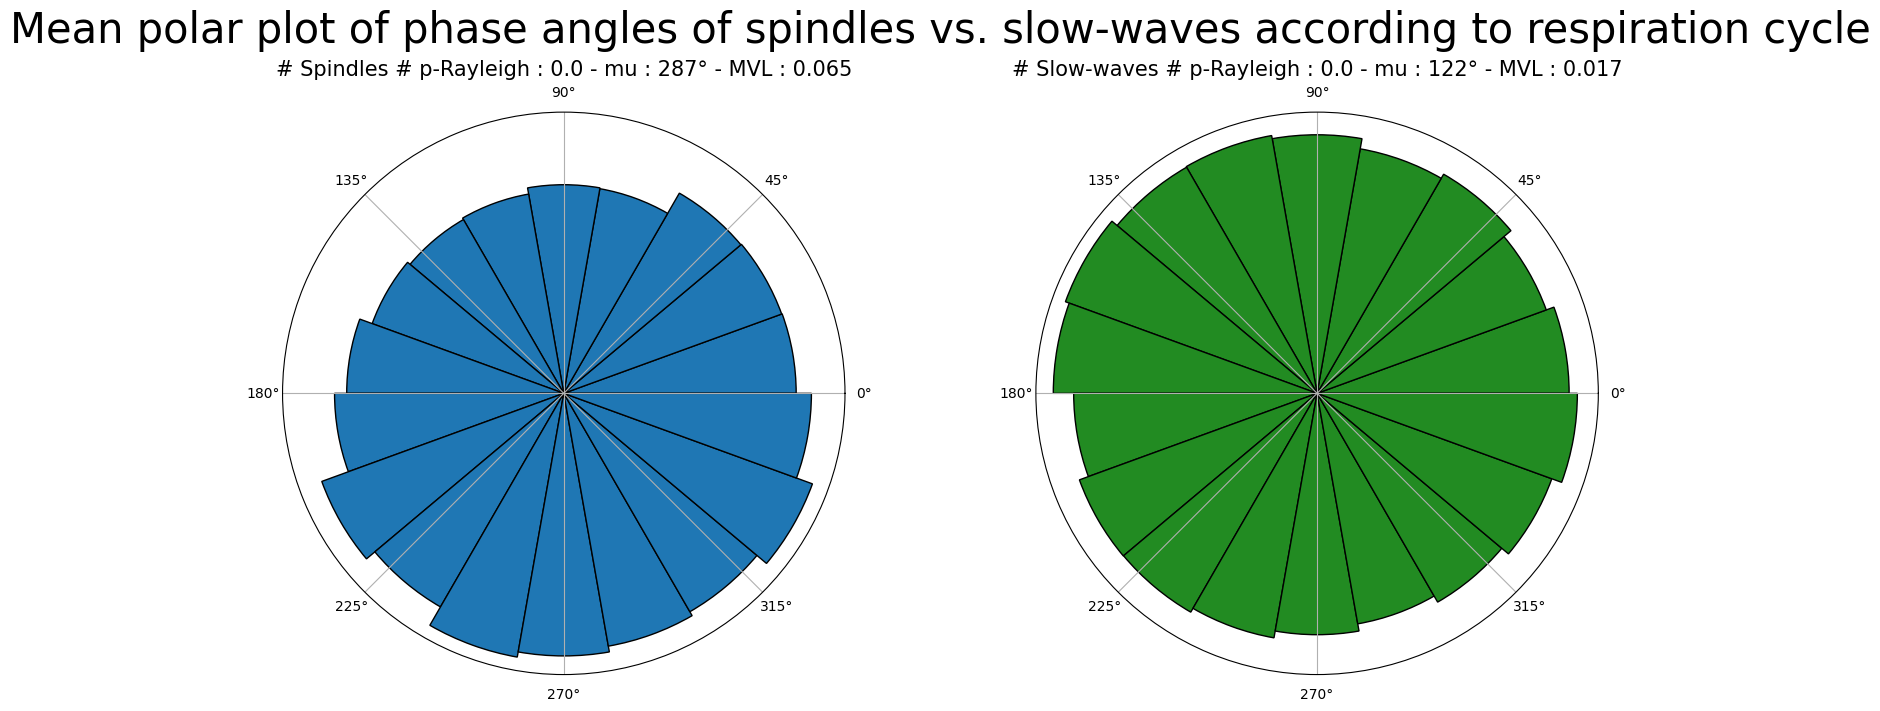

In [14]:
fig, axs = plt.subplots(ncols = 2, subplot_kw=dict(projection = 'polar'), figsize = (15,7), constrained_layout = True)
fig.suptitle(f'Mean polar plot of phase angles of spindles vs. slow-waves according to respiration cycle', fontsize = 30)
bins = 18

for col, event_kind in enumerate(['Spindles','Slow-waves']):
    if event_kind == 'Spindles':
        angles_events = sp_angles
        color = None
    elif event_kind == 'Slow-waves':
        angles_events = sw_angles
        color = 'forestgreen'      
    
    ax = axs[col]
    angles = angles_events['angle']
    p, mu , r = get_circ_features(angles)
    ax.hist(angles, bins = bins, density = False, edgecolor = 'black', color = color)
    ax.set_rticks([])
    ax.set_title(f'# {event_kind} # p-Rayleigh : {round(p, 4)} - mu : {int(mu)}° - MVL : {round(r, 3)}', fontsize = 15, y = 1.05)
if savefig:
    plt.savefig('../presentation_5/mean_polar_plot', bbox_inches = 'tight')

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pycircstat/tests.py:416: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  warnings.warn(
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pycircstat/tests.py:416: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  warnings.warn(
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pycircstat/tests.py:416: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  warnings.warn(
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pycircstat/tests.py:416: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  warnings.warn(
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pycircstat/tests.py:416: UserWarning: Test not applicable. Average resultant vector length < 0.45.
  warnings.warn(
/home/valentin.

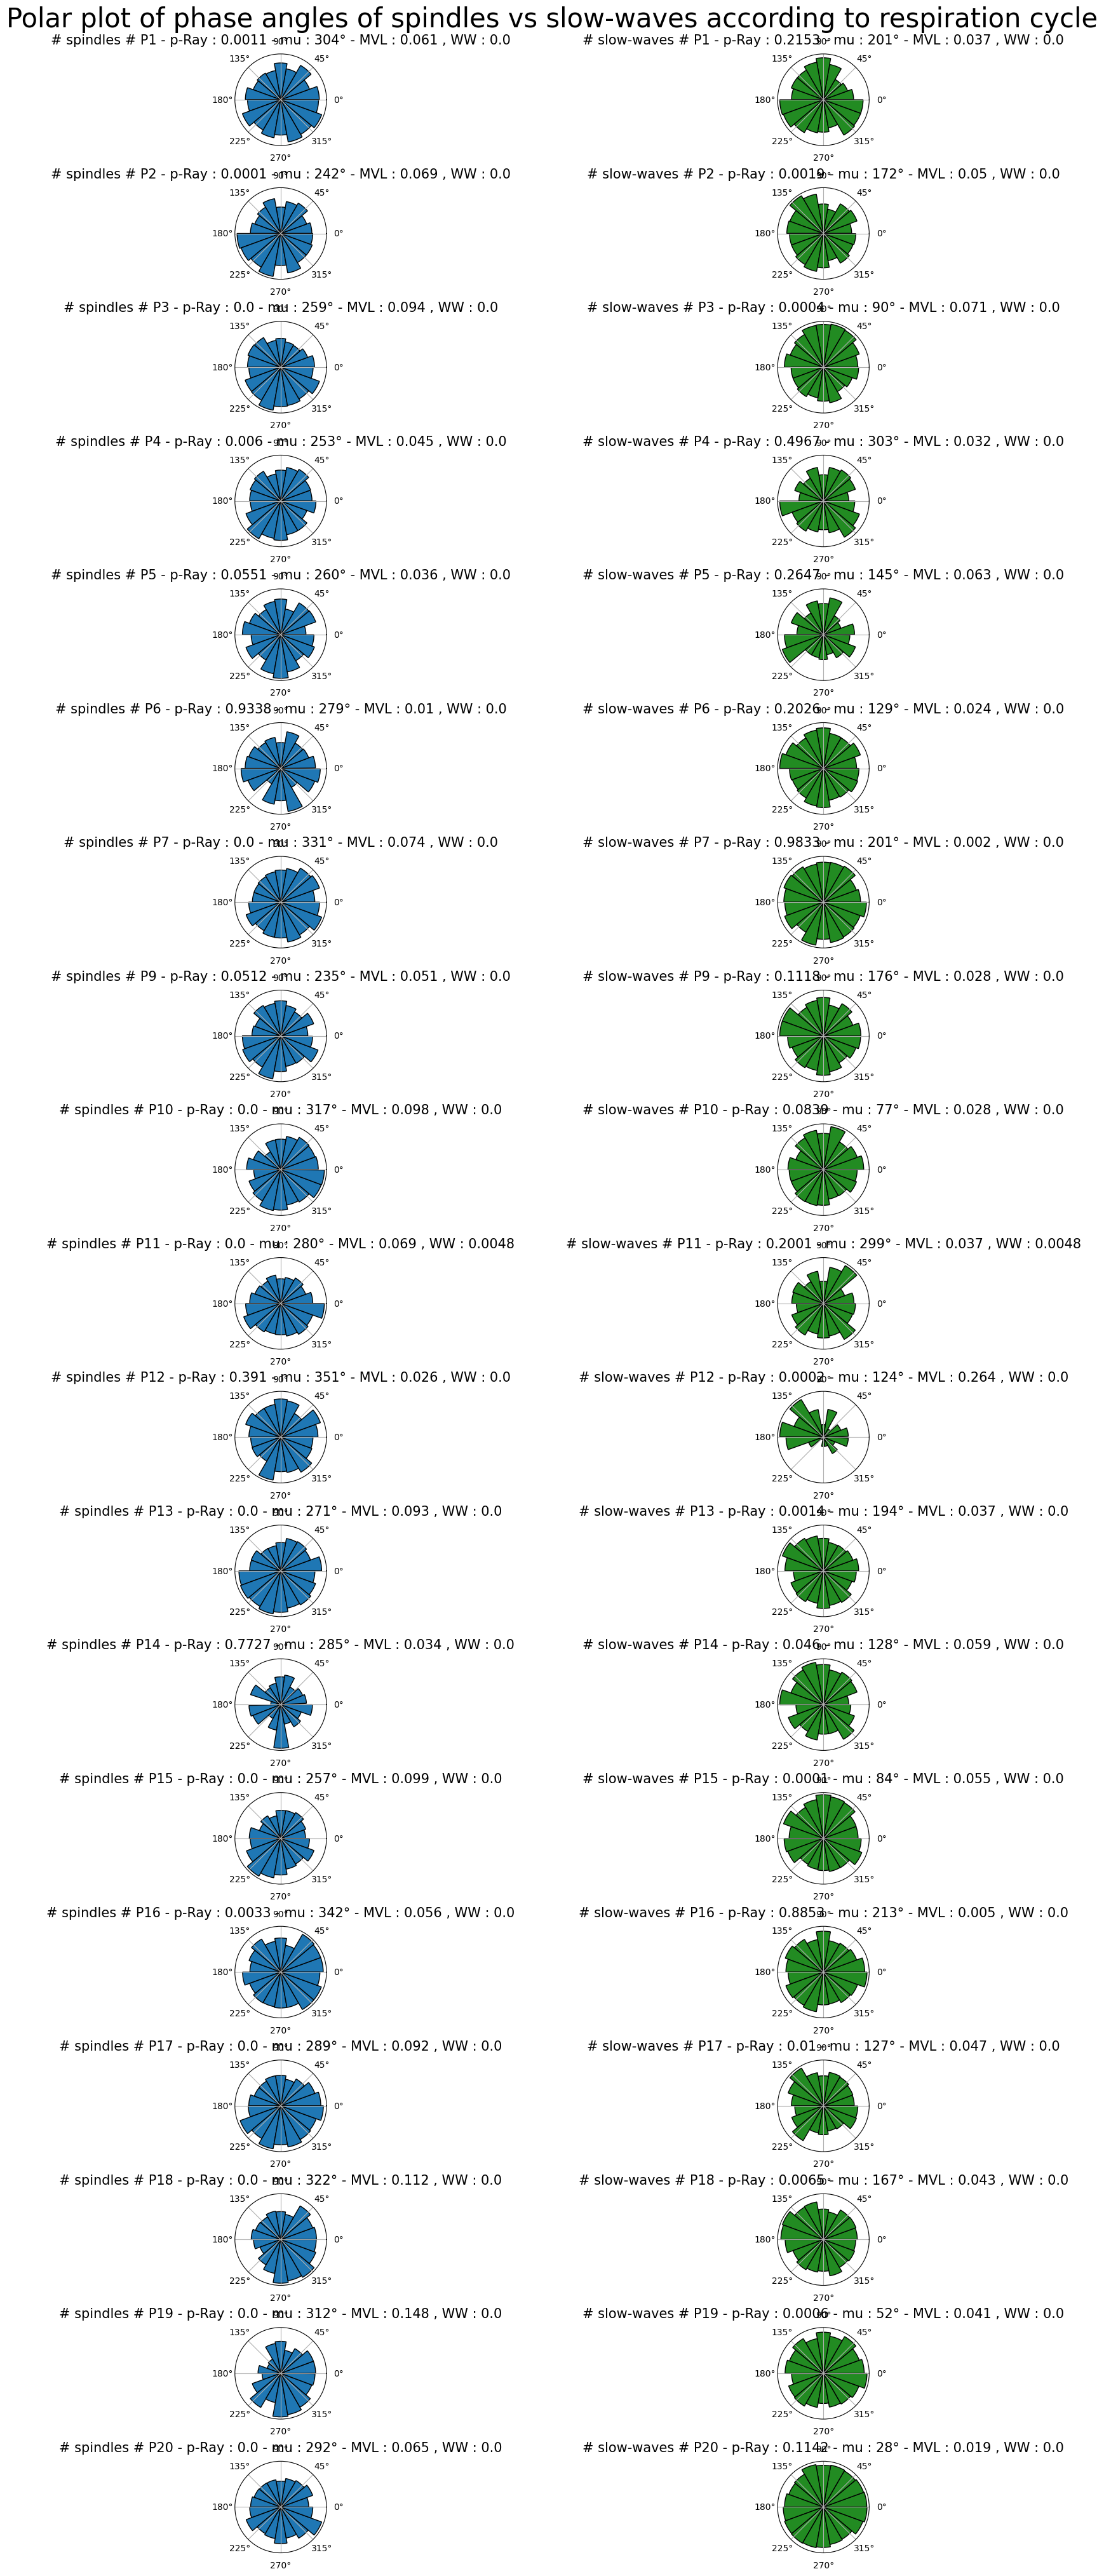

In [15]:
fig, axs = plt.subplots(nrows = len(patients), ncols = 2, subplot_kw=dict(projection = 'polar'), figsize = (17,40), constrained_layout = True)
fig.suptitle(f'Polar plot of phase angles of spindles vs slow-waves according to respiration cycle', fontsize = 30, y = 1.01)
bins = 18
for row, patient in enumerate(patients): 
    sp_angles_patient = sp_angles[sp_angles['patient'] == patient]['angle']
    sw_angles_patient = sw_angles[sw_angles['patient'] == patient]['angle']
    
    p_ww, T = watson_williams(sp_angles_patient, sw_angles_patient)
    
    for col, event_kind in enumerate(['spindles','slow-waves']):
        if event_kind == 'spindles':
            angles_events = sp_angles_patient
            color = None
        elif event_kind == 'slow-waves':
            angles_events = sw_angles_patient
            color = 'forestgreen'

        ax = axs[row, col]
        p, mu , r = get_circ_features(angles_events)
        ax.hist(angles_events, bins = bins, density = True, edgecolor = 'black', color = color)
        ax.set_rticks([])
        ax.set_title(f'# {event_kind} # {patient} - p-Ray : {round(p, 4)} - mu : {int(mu)}° - MVL : {round(r, 3)} , WW : {round(p_ww, 4)}', fontsize = 15, y = 1.05)
if savefig:
    plt.savefig('../presentation_5/detailed_polar_plot_williams', bbox_inches = 'tight')

In [16]:
rsp = pd.read_excel('../participant_characteristics/mean_resp_features_by_participant.xlsx', index_col = 0).set_index('participant')

In [17]:
rsp

,cycle_num,inspi_index,expi_index,inspi_time,expi_time,cycle_duration,insp_duration,exp_duration,cycle_freq,insp_volume,exp_volume,total_amplitude,insp_amplitude,exp_amplitude,ratio
participant,,,,,,,,,,,,,,,
P1,1822.505491,1.335588e+06,1.335856e+06,5217.142358,5218.185644,2.887187,1.043286,1.843901,0.349600,6.467934,-9.141302,23.259971,9.928025,13.331946,0.363089
P10,1652.722424,1.769532e+06,1.769837e+06,6912.234931,6913.425412,3.296303,1.190481,2.105823,0.307212,69.740357,35.657396,104.993869,73.126338,31.867531,0.365110
P11,1828.425767,1.614466e+06,1.614721e+06,6306.509540,6307.504614,3.409964,0.995073,2.414891,0.296257,2.279946,-10.336774,10.798441,4.331346,6.467095,0.293433
P12,1894.958520,1.842146e+06,1.842523e+06,7195.883879,7197.353860,3.884702,1.469981,2.414721,0.261459,10.733826,-2.811277,14.513609,9.644822,4.868787,0.381404
P13,2690.882692,2.334553e+06,2.334839e+06,9119.347271,9120.462916,3.487380,1.115645,2.371735,0.290382,15.092573,-25.319810,51.448863,22.297250,29.151612,0.322279
P14,6995.486769,1.893986e+06,1.894397e+06,7398.382664,7399.988714,3.878761,1.606050,2.272711,0.260686,4.744390,-0.936073,5.684229,4.367288,1.316941,0.415478
P15,2428.309372,2.681687e+06,2.682108e+06,10475.338967,10476.983654,4.362338,1.644687,2.717651,0.232306,13.279936,-9.589765,22.503487,12.214418,10.289069,0.380606
P16,2385.500000,2.453786e+06,2.454190e+06,9585.101924,9586.678590,4.072951,1.576665,2.496285,0.247950,9.876294,-7.341197,19.380409,10.054891,9.325518,0.389150
P17,2573.183090,2.335104e+06,2.335399e+06,9121.501192,9122.651142,3.537278,1.149950,2.387328,0.284878,5.859126,-18.634524,25.346541,8.781098,16.565443,0.326740


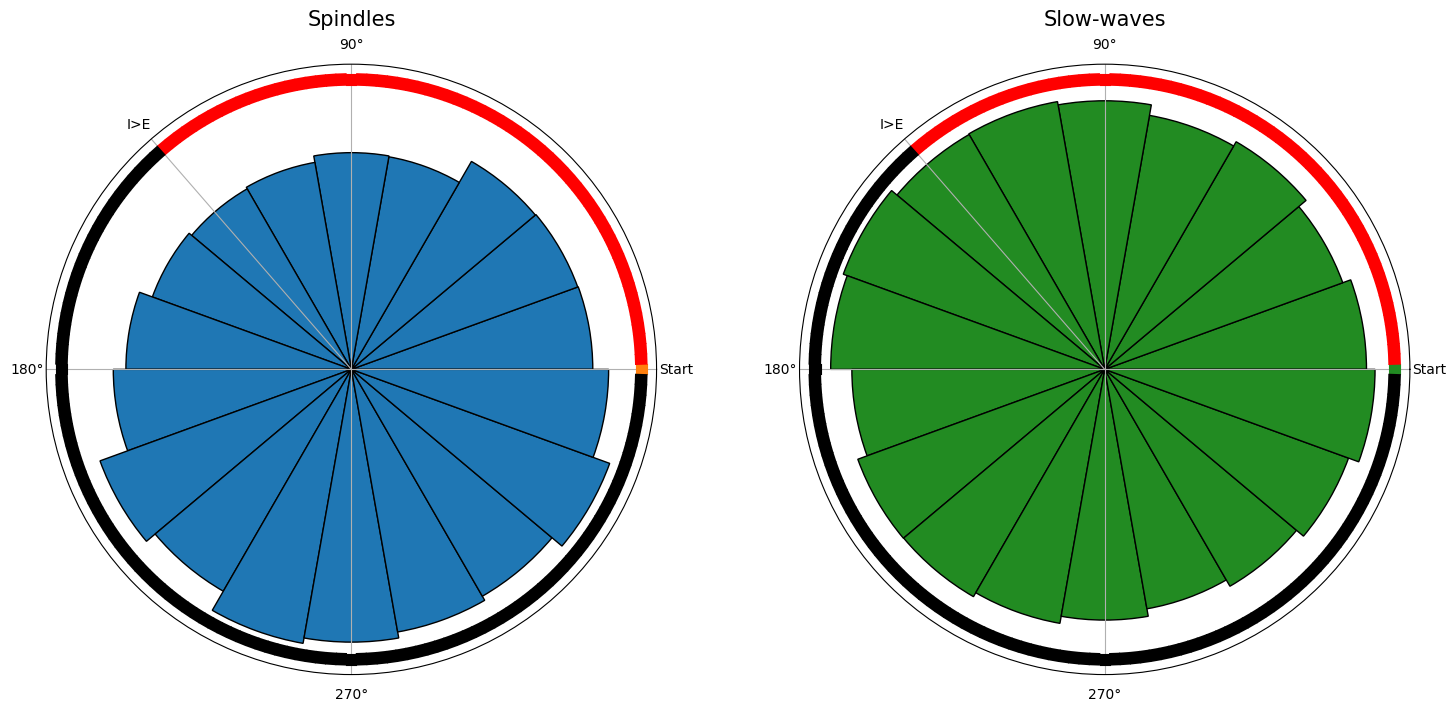

In [18]:
fig, axs = plt.subplots(ncols = 2, subplot_kw=dict(projection = 'polar'), figsize = (15,7), constrained_layout = True)
bins = 18

for col, event_kind in enumerate(['Spindles','Slow-waves']):
    if event_kind == 'Spindles':
        angles_events = sp_angles
        color = None
    elif event_kind == 'Slow-waves':
        angles_events = sw_angles
        color = 'forestgreen'      
    
    ax = axs[col]
    angles = angles_events['angle']
    p, mu , r = get_circ_features(angles)
    ax.hist(angles, bins = bins, density = False, edgecolor = 'black', color = color)
    ax.set_rticks([])
    ax.set_title(event_kind, fontsize = 15, y = 1.05)
    
    tick = [ax.get_rmax()*0.995, ax.get_rmax() * 0.99]
    tick_pos = rsp['ratio'].mean() * 360
    for t in np.deg2rad(np.arange(0, 360, 2)):
        if t <= np.deg2rad(tick_pos) and t > 0:
            color = 'r'
        elif t >= np.deg2rad(tick_pos) and t <= np.deg2rad(360):
            color = 'k'
        ax.plot([t, t], tick, lw=8, color=color)
    ax.set_xticks(np.deg2rad([0, 90 , tick_pos , 180 , 270]))
    ax.set_xticklabels(['Start', '90°', 'I>E', '180°','270°'])
    
if savefig:
    if save_type == 'png':
        plt.savefig('../article/mean_polar_plot', bbox_inches = 'tight', dpi = 300)
    elif save_type == 'eps':
        plt.savefig('../article/mean_polar_plot.eps', format = 'eps', bbox_inches = 'tight', dpi = 300)
    elif save_type == 'tiff':
        plt.savefig('../article/mean_polar_plot.tif', format = 'tif', bbox_inches = 'tight', dpi = 300)


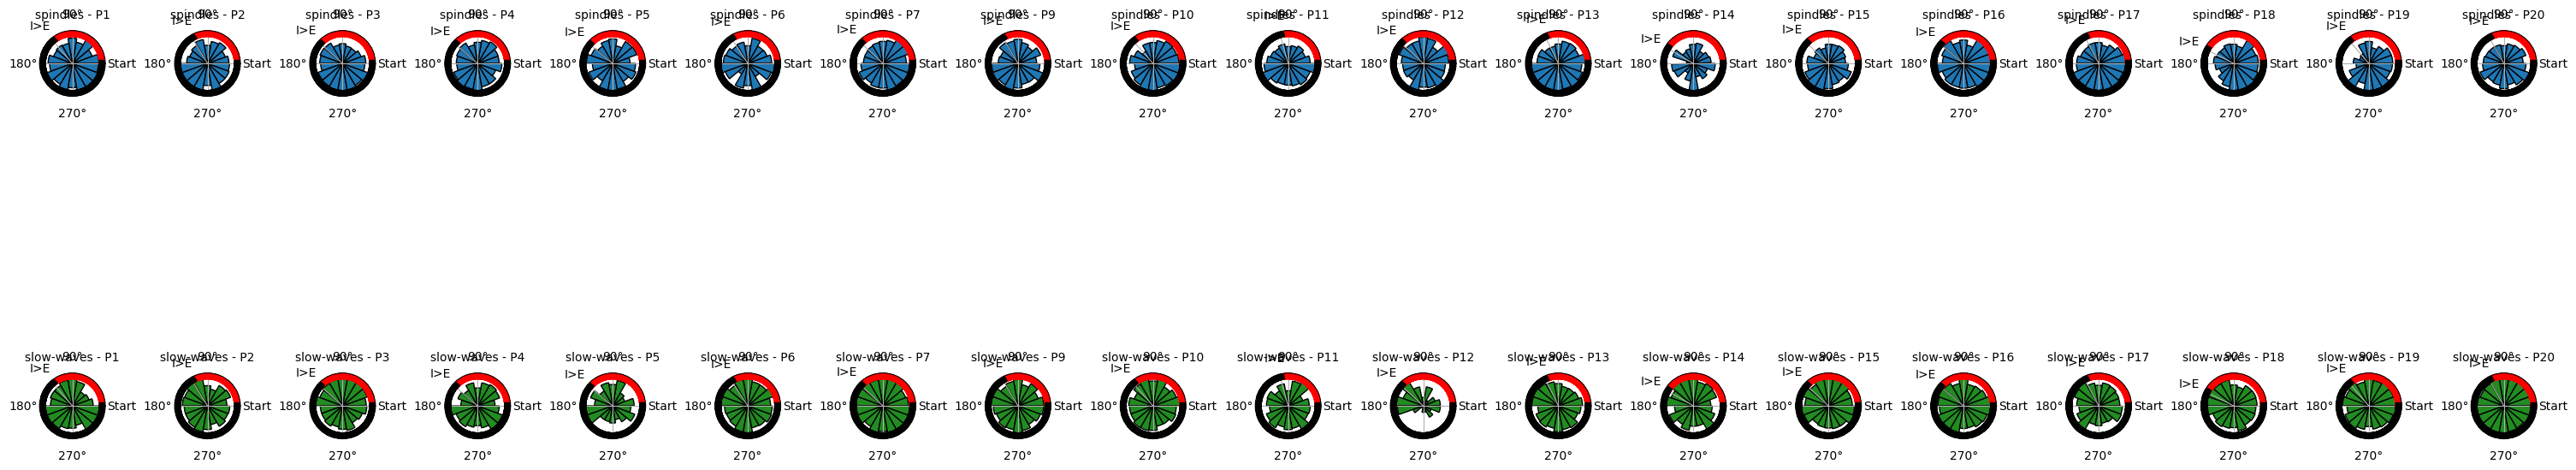

In [19]:
fig, axs = plt.subplots(ncols = len(patients), nrows = 2, subplot_kw=dict(projection = 'polar'), figsize = (30,8), constrained_layout = True)
bins = 18
for col, patient in enumerate(patients): 
    sp_angles_patient = sp_angles[sp_angles['patient'] == patient]['angle']
    sw_angles_patient = sw_angles[sw_angles['patient'] == patient]['angle']
    
    # p_ww, T = watson_williams(sp_angles_patient, sw_angles_patient)
    
    for row, event_kind in enumerate(['spindles','slow-waves']):
        if event_kind == 'spindles':
            angles_events = sp_angles_patient
            color = None
        elif event_kind == 'slow-waves':
            angles_events = sw_angles_patient
            color = 'forestgreen'

        ax = axs[row, col]
        p, mu , r = get_circ_features(angles_events)
        ax.hist(angles_events, bins = bins, density = True, edgecolor = 'black', color = color)
        ax.set_rticks([])
        ax.set_title(f'{event_kind} - {patient}', fontsize = 10, y = 1.08)
        
        tick = [ax.get_rmax()*0.995, ax.get_rmax() * 0.99]
        tick_pos = rsp.loc[patient, 'ratio'] * 360
        for t in np.deg2rad(np.arange(0, 360, 2)):
            if t <= np.deg2rad(tick_pos) and t > 0:
                color = 'r'
            elif t >= np.deg2rad(tick_pos) and t <= np.deg2rad(360):
                color = 'k'
            ax.plot([t, t], tick, lw=8, color=color)
        ax.set_xticks(np.deg2rad([0, 90 , tick_pos , 180 , 270]))
        ax.set_xticklabels(['Start', '90°', 'I>E', '180°','270°'])
        
if savefig:
    if save_type == 'png':
        plt.savefig('../article/detailed_polar_plot', bbox_inches = 'tight', dpi = 300)
    elif save_type == 'eps':
        plt.savefig('../article/detailed_polar_plot.eps', format = 'eps', bbox_inches = 'tight', dpi = 300)
    elif save_type == 'tiff':
        plt.savefig('../article/detailed_polar_plot.tif', format = 'tif', bbox_inches = 'tight', dpi = 300)

In [20]:
# participant_to_subjects = {'P1':'S1','P2':'S2','P3':'S3','P4':'S4','P5':'S5','P6':'S6','P7':'S7','P8':'S8','P9':'S9','P10':'S10'}

# fig, axs = plt.subplots(ncols = len(patients), nrows = 2, subplot_kw=dict(projection = 'polar'), figsize = (30,8), constrained_layout = True)
# bins = 18
# for col, patient in enumerate(patients): 
#     sp_angles_patient = sp_angles[sp_angles['patient'] == patient]['angle']
#     sw_angles_patient = sw_angles[sw_angles['patient'] == patient]['angle']
    
#     # p_ww, T = watson_williams(sp_angles_patient, sw_angles_patient)
    
#     for row, event_kind in enumerate(['spindles','slow-waves']):
#         if event_kind == 'spindles':
#             angles_events = sp_angles_patient
#             color = None
#         elif event_kind == 'slow-waves':
#             angles_events = sw_angles_patient
#             color = 'forestgreen'

#         ax = axs[row, col]
#         p, mu , r = get_circ_features(angles_events)
#         ax.hist(angles_events, bins = bins, density = True, edgecolor = 'black', color = color)
#         ax.set_rticks([])
#         ax.set_title(f'{event_kind} - {participant_to_subjects[patient]}', fontsize = 10, y = 1.08)
        
#         tick = [ax.get_rmax()*0.995, ax.get_rmax() * 0.99]
#         tick_pos = rsp.loc[patient, 'ratio'] * 360
#         for t in np.deg2rad(np.arange(0, 360, 2)):
#             if t <= np.deg2rad(tick_pos) and t > 0:
#                 color = 'r'
#             elif t >= np.deg2rad(tick_pos) and t <= np.deg2rad(360):
#                 color = 'k'
#             ax.plot([t, t], tick, lw=8, color=color)
#         ax.set_xticks(np.deg2rad([0, 90 , tick_pos , 180 , 270]))
#         ax.set_xticklabels(['Start', '90°', 'I>E', '180°','270°'])
        
# if savefig:
#     if save_type == 'png':
#         plt.savefig('../article/detailed_polar_plot', bbox_inches = 'tight', dpi = 300)
#     elif save_type == 'eps':
#         plt.savefig('../article/detailed_polar_plot.eps', format = 'eps', bbox_inches = 'tight', dpi = 300)
#     elif save_type == 'tiff':
#         plt.savefig('../article/detailed_polar_plot_Subject.tif', format = 'tif', bbox_inches = 'tight', dpi = 300)

In [21]:
tables = []

for event_kind in ['Spindles','Slow-waves']:
    if event_kind == 'Spindles':
        angles_events = sp_angles
    elif event_kind == 'Slow-waves':
        angles_events = sw_angles
    rows = []
    for participant in patients:
        angles = angles_events[angles_events['patient'] == participant]['angle']
        p, mu , r = get_circ_features(angles)
        
        if p > 0.05:
            stars = 'ns'
        elif p < 0.05 and p >= 0.01:
            stars = '*'
        elif p < 0.01 and p >= 0.001:
            stars = '**'
        elif p < 0.001:
            stars = '***'
        
        row = [participant, event_kind , p, stars, int(mu) , round(r, 3)]
        rows.append(row)
    stats_table = pd.DataFrame(rows, columns = ['Participant', 'Event','p-Rayleigh', 'Rayleigh Significance', 'Mean Direction (°)','Mean Vector Length']) 
    if event_kind == 'Slow-waves':
        stats_table = stats_table.drop(columns = 'Participant')
    tables.append(stats_table)
    
whole_stats_table = pd.concat(tables, axis = 1)
if savefig:
    whole_stats_table.to_excel('../article/stats_table.xlsx')

In [22]:
whole_stats_table

,Participant,Event,p-Rayleigh,Rayleigh Significance,Mean Direction (°),Mean Vector Length,Event,p-Rayleigh,Rayleigh Significance,Mean Direction (°),Mean Vector Length
0,P1,Spindles,1.117582e-03,**,304,0.061,Slow-waves,0.215287,ns,201,0.037
1,P2,Spindles,5.410616e-05,***,242,0.069,Slow-waves,0.001894,**,172,0.050
2,P3,Spindles,1.717493e-12,***,259,0.094,Slow-waves,0.000381,***,90,0.071
3,P4,Spindles,6.037268e-03,**,253,0.045,Slow-waves,0.496743,ns,303,0.032
4,P5,Spindles,5.505851e-02,ns,260,0.036,Slow-waves,0.264669,ns,145,0.063
5,P6,Spindles,9.337597e-01,ns,279,0.010,Slow-waves,0.202605,ns,129,0.024
6,P7,Spindles,1.186396e-09,***,331,0.074,Slow-waves,0.983313,ns,201,0.002
7,P9,Spindles,5.120396e-02,ns,235,0.051,Slow-waves,0.111803,ns,176,0.028
8,P10,Spindles,3.448518e-08,***,317,0.098,Slow-waves,0.083889,ns,77,0.028
9,P11,Spindles,3.249083e-06,***,280,0.069,Slow-waves,0.200102,ns,299,0.037


In [23]:
rows = []
for participant in patients:
    sp_angles_participant = sp_angles[sp_angles['patient'] == participant]['angle'].values
    bin_values , x = np.histogram(sp_angles_participant, bins = 2)
    norm_bin_values = bin_values / sum(bin_values)
    norm_bin_values = np.round(norm_bin_values, 3)
    rows.append([participant, 'first half', norm_bin_values[0]])
    rows.append([participant, 'second half', norm_bin_values[1]])
bins_2 = pd.DataFrame(rows, columns = ['participant', 'half', 'count'])

<BarContainer object of 19 artists>
<BarContainer object of 19 artists>


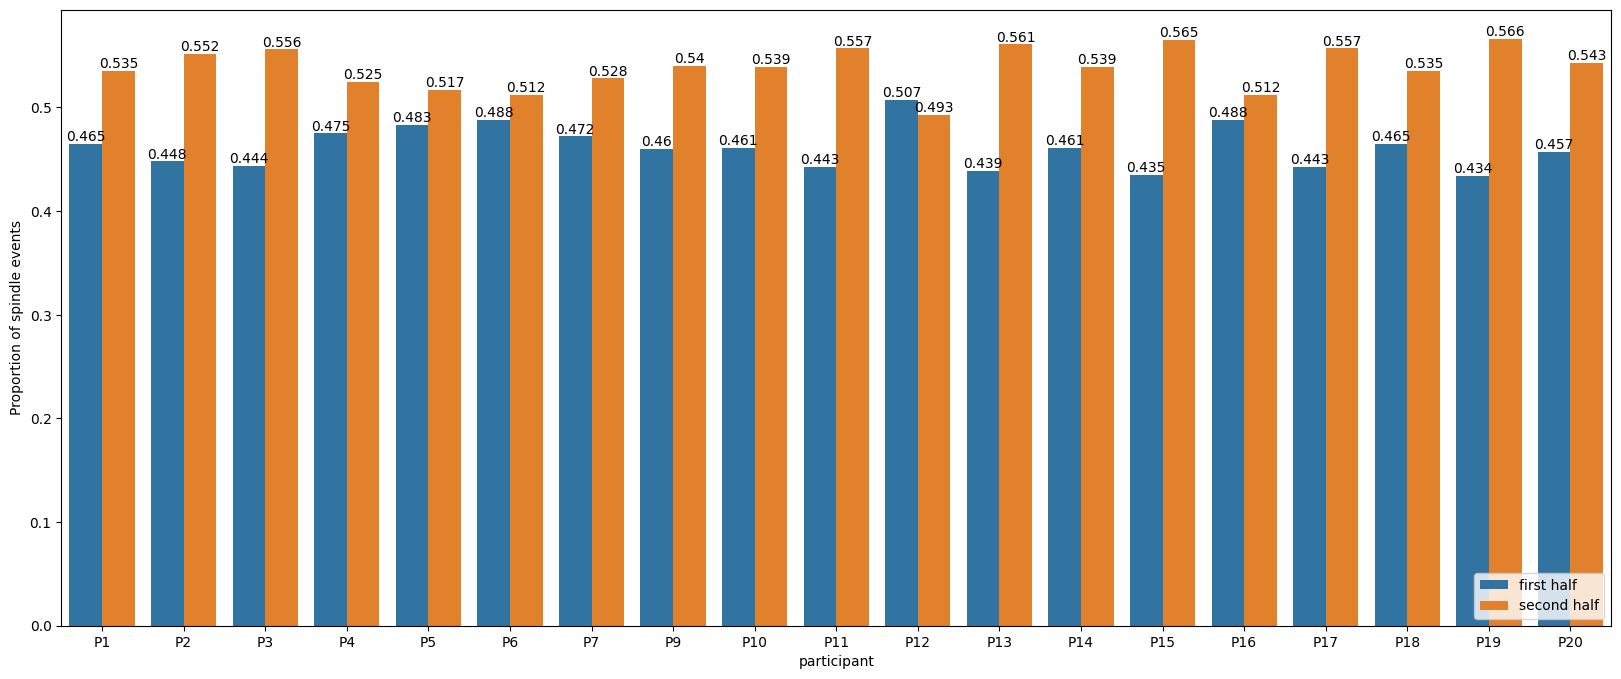

In [24]:
fig, ax = plt.subplots(figsize = (20,8))
sns.barplot(data=bins_2, x = 'participant', hue = 'half', y = 'count', ax=ax)
ax.set_ylabel('Proportion of spindle events')
ax.legend(loc = 4)
# ttest = pg.ttest(x= bins_2[bins_2['half']=='second half']['count'] , y= 0.5)
# p = ttest.loc['T-test', 'p-val'].round(4)
# cohen = ttest.loc['T-test', 'cohen-d'].round(4)
# ax.set_title(f'T-test against 0.5 : p={p} ; cohen-d = {cohen}')
for i in ax.containers:
    print(i)
    ax.bar_label(i,)
    
if savefig: 
    plt.savefig('../article/2_bins')